1. Get the distribution of image zeros per month per band
2. Compute the distribution of valid months per chip
2. Compute the frequency of chipid's with more than 2 months of 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import os
import torch
from bioMass.dataloader import train_df, read_yearly_tiffs

def plot_months(data, months_list, band_no, cmap='viridis'):
    
    fig, ax = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(10, 8))
    list(map(lambda axi: axi.set_axis_off(), ax.ravel()))
    plt.tight_layout()


    for month, month_data in zip(months_list, data):
        col = month%4
        row = month//4
        ax[row][col].imshow(month_data[band_no], cmap=cmap)
        
    plt.show()
    
    return

%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

/home/ubuntu/Thesis/miniconda3/envs/bioMass/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_warm_data(data, months_list):
    warm_months = [0, 8, 9, 10, 11] # Sep, May, June, July, August
    
    data_warm = []
    months_list_warm = []
    for m, d in zip(months_list, data):
        if m in warm_months:
            # compute number of zeros and only append if more than 60%
            pct_zeros = (d==0).sum()/len(d.flatten())
            if pct_zeros>0.6:
                data_warm.append(d)
                months_list_warm.append(m)
                
    if len(months_list_warm)==0:
        data_warm.append(np.zeros_like(d))
        months_list_warm.append(-1)
        
    return data_warm, months_list_warm

In [70]:
month_map = {
    0: 'Sep', 1: 'Oct', 2: 'Nov', 3: 'Dec',
    4: 'Jan', 5: 'Feb', 6: 'Mar', 7: 'Apr',
    8: 'May', 9: 'Jun', 10: 'Jul', 11: 'Aug'
}

In [93]:
chip_sample = train_df.chip_id.sample(1000).values

In [94]:
zeros = []

for chipid in tqdm(chip_sample):
    data, months_list, agbm = read_yearly_tiffs(chipid, 'S2')
    zero_freq_monthly = []

    for month, month_data in zip(months_list, data):
        zeros_per_band = [(x==0).sum() for x in month_data]
        zeros_per_band = np.array(zeros_per_band)/(256*256) # size of our images is 256x256
        zero_freq_monthly.append(zeros_per_band)

    aux_zeros = pd.DataFrame(zero_freq_monthly, index=months_list).T.reset_index()
    aux_zeros.rename(columns={'index':'band_no'}, inplace=True)
    
    zeros.append(aux_zeros)

100%|███████████████████████████████████| 1000/1000 [27:40<00:00,  1.66s/it]


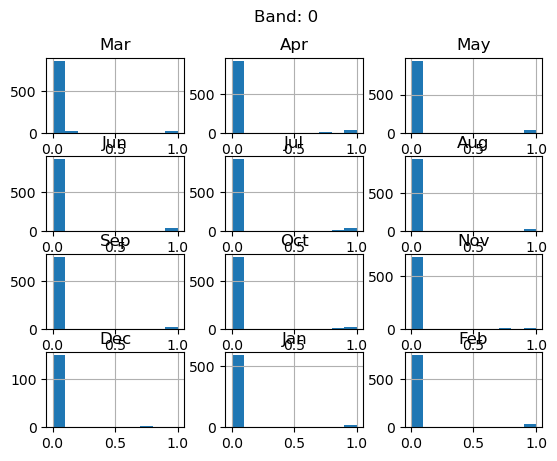

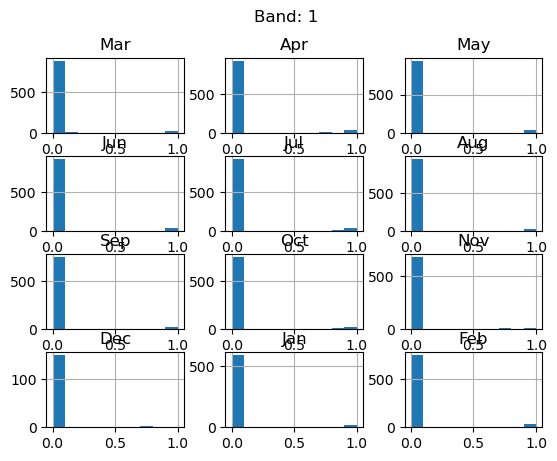

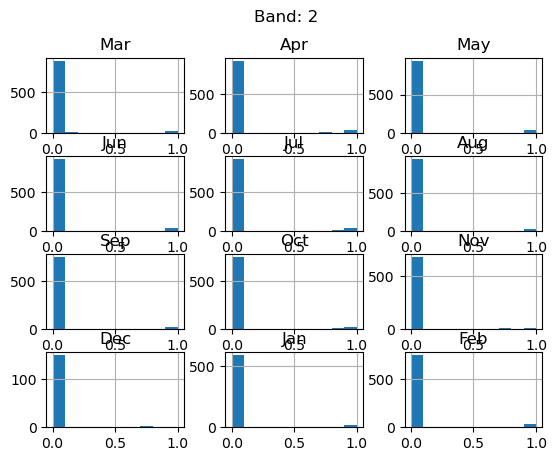

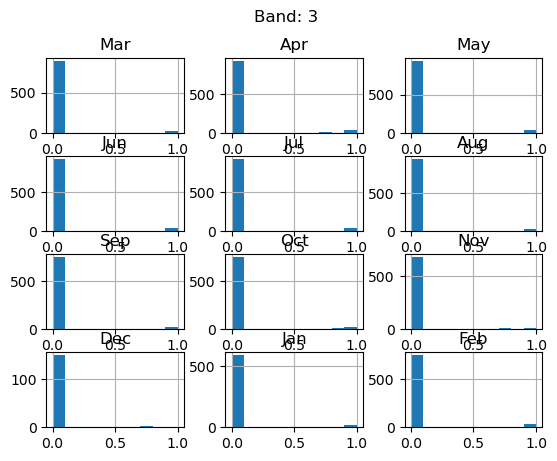

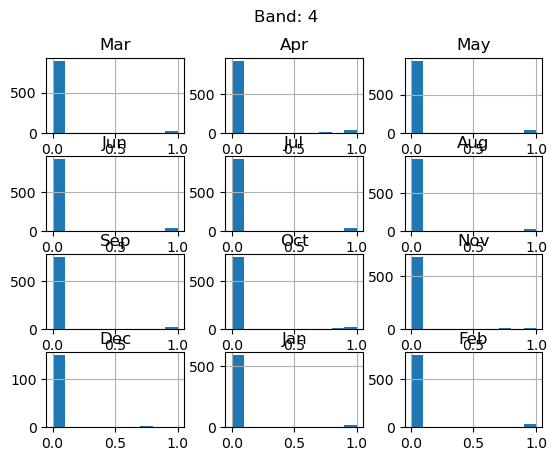

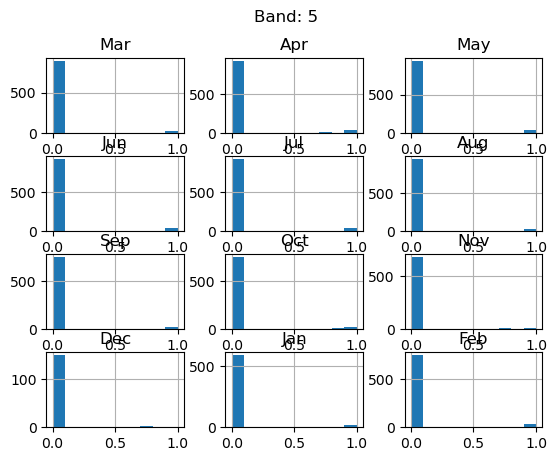

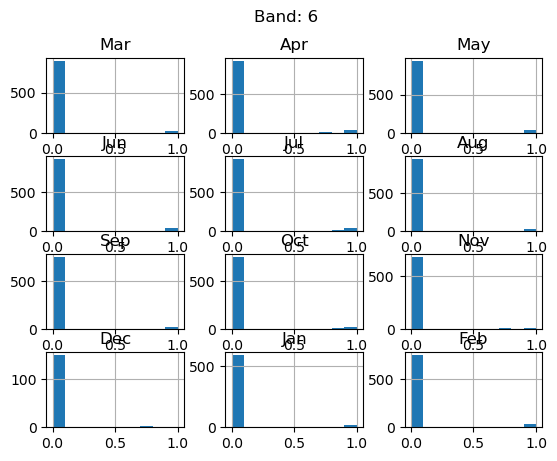

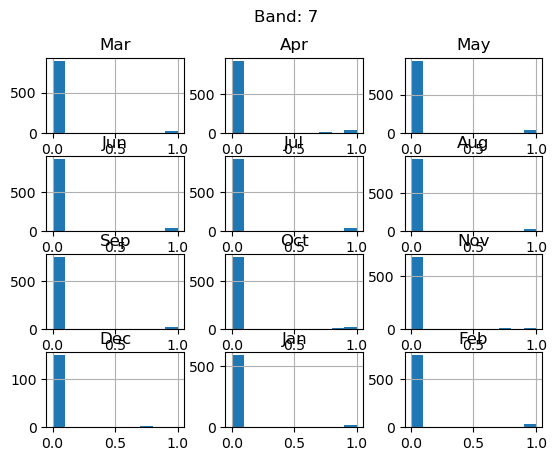

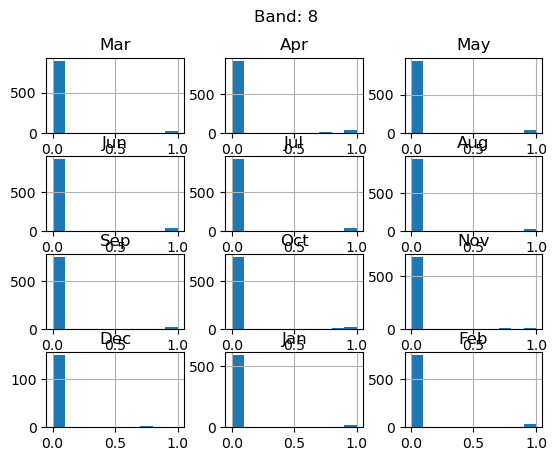

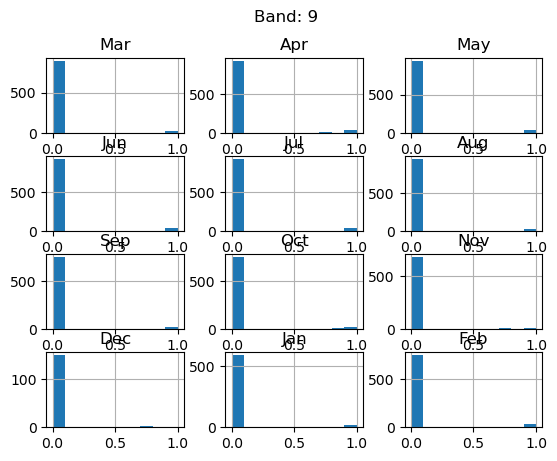

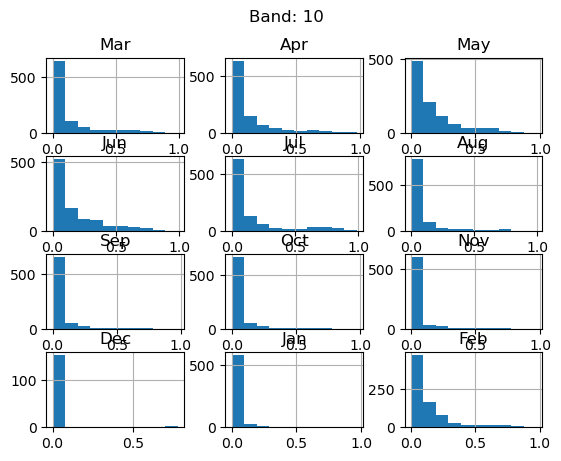

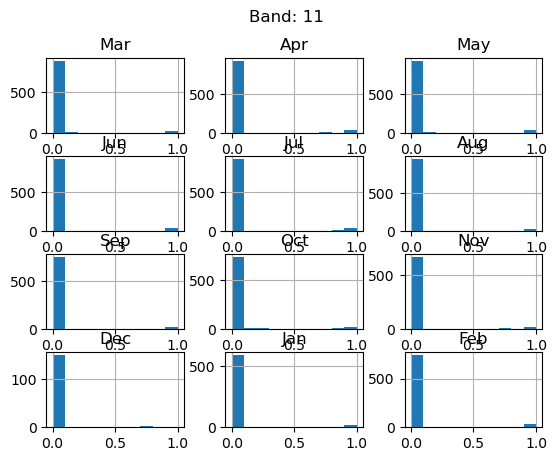

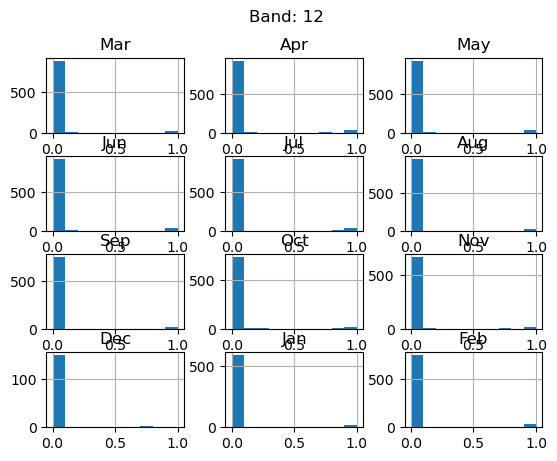

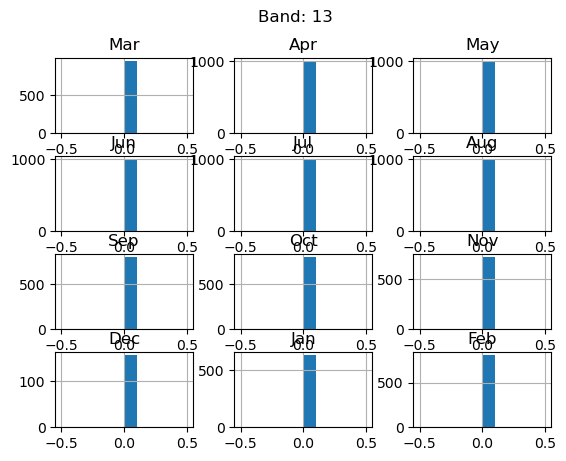

In [97]:
zeros_df = pd.concat(zeros)
zeros_df.rename(columns=month_map, inplace=True)

for band_no in range(14):
    df = zeros_df[zeros_df.band_no==band_no].drop('band_no', axis=1)
    df.hist()
    plt.suptitle('Band: ' + str(band_no))
    plt.show()